# Bangkok Neighborhood Battle : What is the Best New house Project

## Introduction

Hi everyone I'm mean from thailand and I live in Bangkok.Now I start my work life for a year and it's pretty good so I seek for a nice detached house for my future, But it has many many New house projects in Bangkok today !!!.

I don't have any ideas that which projects is good enough and Are they locations is worth if I invest in this project today. Luckyly, I study DataSci with cousera, so I will use data from house selling platform and Foursquare API to comparison house project in Bangkok by consider their function and sub-distrcit (neighborhood).

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

## Data section

I scarpping data form https://www.baania.com/th. It's a real-estate e-commerce platform in thailand.

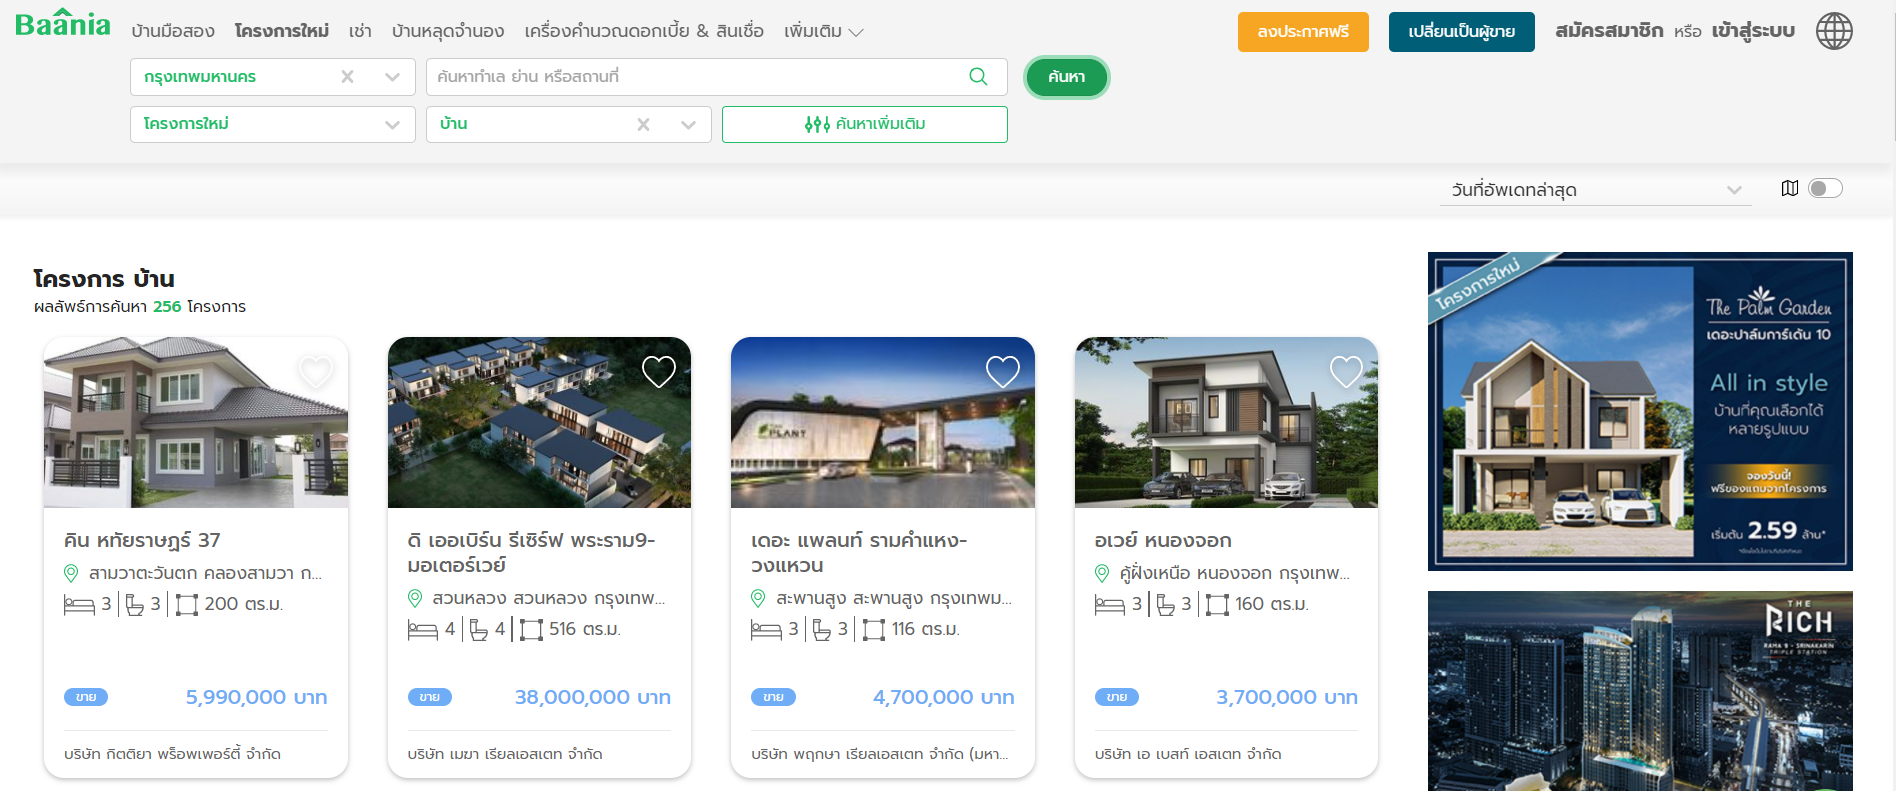

In [2]:
def Get_BaaniaData(Pages):
    df=[]
    for n in range (1,Pages+1):
        link = "https://www.baania.com/th/s/%E0%B8%97%E0%B8%B1%E0%B9%89%E0%B8%87%E0%B8%AB%E0%B8%A1%E0%B8%94/project?mapMove=true&page={}&propertyType=1&province=3781&sellState=on-sale,sale-rent&sort.updated=desc".format(n)
        url = requests.get(link)
        soup = BeautifulSoup(url.content,'html.parser')
        house_list = soup.find_all("div",{"class":"mb-3 col"})
        for house in house_list:
            cell = {}
            cell["Name"] = house.find("div",{"class":"Title__Wrapper-gataha-0 eHsXv card-title mb-1 small"}).text
            cell["Price"] = house.find("div",{"class":"card-price-number text-right text-truncate ml-auto text-info"}).text
            cell["Location"] = house.find("div",{"class":"card-address"}).text
            cell["Bedroom"] = house.find_all("span",{"class":"card-basic-info"})[0].text
            cell["Bathroom"] = house.find_all("span",{"class":"card-basic-info"})[1].text
            if len(house.find_all("span",{"class":"card-basic-info"}))==3:
                cell["Area"] = house.find_all("span",{"class":"card-basic-info"})[2].text
            else:
                cell["Area"] = ""
            df.append(cell)
    house_data = pd.DataFrame(df)
    return house_data

This is a function for web scrapping ,but you need to fill total pages numbers that you need

In [3]:
BNP_data = Get_BaaniaData(6)

Bangkok New Projects (BNP)

In [4]:
BNP_data.head()

,Name,Price,Location,Bedroom,Bathroom,Area
0,คิน หทัยราษฏร์ 37,"5,990,000 บาท",สามวาตะวันตก คลองสามวา กรุงเทพมหานคร,3,3,200 ตร.ม.
1,ดิ เออเบิร์น รีเซิร์ฟ พระราม9-มอเตอร์เวย์,"38,000,000 บาท",สวนหลวง สวนหลวง กรุงเทพมหานคร,4,4,516 ตร.ม.
2,เดอะ แพลนท์ รามคำแหง-วงแหวน,"4,700,000 บาท",สะพานสูง สะพานสูง กรุงเทพมหานคร,3,3,116 ตร.ม.
3,อเวย์ หนองจอก,"3,700,000 บาท",คู้ฝั่งเหนือ หนองจอก กรุงเทพมหานคร,3,3,160 ตร.ม.
4,ฟอเรสต้า นิมิตใหม่ 40,"3,000,000 บาท",สามวาตะวันออก คลองสามวา กรุงเทพมหานคร,3,3,149 ตร.ม.


From website, I get \
1.House Project name (Name) \
2.Price in Thai baht\
3.Location which has district(borough) and sub-district(neighborhood) in same line\
4.Numbers of bedrooms\
5.Numbers of bathrooms\
6.House area usage

In [5]:
BNP_data.shape

(256, 6)

In [6]:
sub_district = []
district =[]
for row in BNP_data["Location"]:
    sub_district.append(row.split(" ")[0])
    district.append(row.split(" ")[1])

In [7]:
BNP_data["Sub_district"] = sub_district
BNP_data["District"] = district

In [8]:
BNP_data.drop(columns="Location",inplace=True)

Split District and Sub-District in location for analyze by Foursqaure in next step

In [9]:
BNP_data.head()

,Name,Price,Bedroom,Bathroom,Area,Sub_district,District
0,คิน หทัยราษฏร์ 37,"5,990,000 บาท",3,3,200 ตร.ม.,สามวาตะวันตก,คลองสามวา
1,ดิ เออเบิร์น รีเซิร์ฟ พระราม9-มอเตอร์เวย์,"38,000,000 บาท",4,4,516 ตร.ม.,สวนหลวง,สวนหลวง
2,เดอะ แพลนท์ รามคำแหง-วงแหวน,"4,700,000 บาท",3,3,116 ตร.ม.,สะพานสูง,สะพานสูง
3,อเวย์ หนองจอก,"3,700,000 บาท",3,3,160 ตร.ม.,คู้ฝั่งเหนือ,หนองจอก
4,ฟอเรสต้า นิมิตใหม่ 40,"3,000,000 บาท",3,3,149 ตร.ม.,สามวาตะวันออก,คลองสามวา


Get Latitude and Lontitude data for each sub-district

In [11]:
latitude=[]
longitude=[]
for sub in BNP_data["Sub_district"]:
    address = sub
    geolocator = Nominatim(user_agent="bkk_explorer")
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

In [12]:
BNP_data["Latitude"] = latitude
BNP_data["Longitude"] = longitude

In [13]:
BNP_data = BNP_data.reindex(columns=['Name','Sub_district','District','Latitude','Longitude','Bedroom','Bathroom','Area','Price'])

In [14]:
BNP_data.head()

,Name,Sub_district,District,Latitude,Longitude,Bedroom,Bathroom,Area,Price
0,คิน หทัยราษฏร์ 37,สามวาตะวันตก,คลองสามวา,13.888578,100.710252,3,3,200 ตร.ม.,"5,990,000 บาท"
1,ดิ เออเบิร์น รีเซิร์ฟ พระราม9-มอเตอร์เวย์,สวนหลวง,สวนหลวง,13.725553,100.627438,4,4,516 ตร.ม.,"38,000,000 บาท"
2,เดอะ แพลนท์ รามคำแหง-วงแหวน,สะพานสูง,สะพานสูง,13.765469,100.690797,3,3,116 ตร.ม.,"4,700,000 บาท"
3,อเวย์ หนองจอก,คู้ฝั่งเหนือ,หนองจอก,13.872420,100.811197,3,3,160 ตร.ม.,"3,700,000 บาท"
4,ฟอเรสต้า นิมิตใหม่ 40,สามวาตะวันออก,คลองสามวา,13.899109,100.760595,3,3,149 ตร.ม.,"3,000,000 บาท"


It takes a huge time to extract new lat and long so I will keep this dataset as excel file

In [17]:
BNP_data.to_excel("Bangkok_newhouse_data.xlsx")

In [18]:
map_house = folium.Map(location=[13.75398,100.50144], zoom_start=11)

# add markers to map
for lat, lng, label in zip(BNP_data['Latitude'], BNP_data['Longitude'], BNP_data['Sub_district']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_house)  
    
map_house